### 1.
 We want to explore the general trend of the conversation data. For this purpose, create a dataframe for each speaker by gathering all his utterances in a single file.
Then write a script that determines the vocabulary set, vocabulary size, total number of tokens, total number of repetitions of words in the same post, total number of confirmation words (e.g., yes, OK, sure), total number of negation tokens, associated to each speaker. Summarize the result in a table, and then draw a subgraph that shows on the same plot the evolution of number of repetitions, number of negation, number of confirmation-like tokens, with respect to the number of tokens employed for each speaker (You may create some subdivision from the total number of tokens to ensure enough datum are used to represent the graphical illustration). Calculate the overall personality for each speaker by averaging over all instances of the original dataset, and comment on possible similarities and differences between speakers and whether some attributes are more associated with some personality patterns.

In [43]:
# Download dataset from GitHub repository
import pandas as pd
url = "https://raw.githubusercontent.com/preke/PELD/main/data/Dyadic_PELD.tsv"
df = pd.read_csv(url, sep='\t')

In [44]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6510 entries, 0 to 6509
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Speaker_1    6510 non-null   object
 1   Speaker_2    6510 non-null   object
 2   Personality  6510 non-null   object
 3   Utterance_1  6510 non-null   object
 4   Utterance_2  6510 non-null   object
 5   Utterance_3  6510 non-null   object
 6   Emotion_1    6510 non-null   object
 7   Emotion_2    6510 non-null   object
 8   Emotion_3    6510 non-null   object
 9   Sentiment_1  6510 non-null   object
 10  Sentiment_2  6510 non-null   object
 11  Sentiment_3  6510 non-null   object
dtypes: object(12)
memory usage: 610.4+ KB
None


In [45]:
# save each speaker with their utterances in separate files
distinct_speakers1 = df['Speaker_1'].unique()
print('speaker 1: ', distinct_speakers1)
for s in distinct_speakers1:
    lines = (pd.concat([df.loc[df['Speaker_1']==s, 'Utterance_1'],
                        df.loc[df['Speaker_1']==s, 'Utterance_3'],
                        df.loc[df['Speaker_2']==s, 'Utterance_2']])
               .dropna()
               .rename('utterance'))
    lines.to_csv(f'{s}_utterances.csv', index=False)

speaker 1:  ['Chandler' 'Joey' 'Rachel' 'Monica' 'Phoebe' 'Ross']


In [46]:
# load each speaker's utterances with a dataframe from the saved files
df_Chandler = pd.read_csv('Chandler_utterances.csv')
df_Monica = pd.read_csv('Monica_utterances.csv')
df_Ross = pd.read_csv('Ross_utterances.csv')
df_Rachel = pd.read_csv('Rachel_utterances.csv')
df_Joey = pd.read_csv('Joey_utterances.csv')
df_Phoebe = pd.read_csv('Phoebe_utterances.csv')

In [47]:
# generate confirmation words set from seed words
from nltk.corpus import wordnet as wn
seed = {'yes', 'yeah', 'yep', 'sure', 'okay', 'ok', 'indeed', 'exactly', 'right',
        'correct', 'absolutely', 'definitely', 'certainly', 'affirmative'}
confirmation_words = set(seed)
for word in list(seed):
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            confirmation_words.add(lemma.name().replace('_', ' '))

print(sorted(confirmation_words))
confirmation_words = list(confirmation_words)

['O.K.', 'OK', 'Oklahoma', 'Sooner State', 'absolutely', 'adjust', 'affirmative', 'affirmatory', 'all right', 'alright', 'approbative', 'approbatory', 'approve', 'approving', 'aright', 'by all odds', 'castigate', 'certain', 'certainly', 'chasten', 'chastise', 'compensate', 'correct', 'correctly', 'counterbalance', 'dead', 'decent', 'decently', 'decidedly', 'decline', 'definitely', 'discipline', 'emphatically', 'even off', 'even out', 'even up', 'exactly', 'fine', 'flop', 'for certain', 'for sure', 'good', 'hunky-dory', 'in good order', 'in spades', 'incisively', 'indeed', 'indisputable', 'just', 'justly', 'make up', 'mightily', 'mighty', 'o.k.', 'objurgate', 'ok', 'okay', 'okeh', 'okey', 'on the button', 'on the dot', 'on the nose', 'optimistic', 'perfectly', 'plausive', 'powerful', 'precisely', 'proper', 'properly', 'rectify', 'redress', 'right', 'right field', 'right hand', 'right on', 'right wing', 'right-hand', 'rightfield', 'rightfulness', 'ripe', 'sanction', 'set', 'slump', 'so',

In [48]:
#  negation word list
negation_words = {
    "no", "not", "n't", "never", "none", "nothing", "nobody", "nowhere",
    "neither", "nor", "barely", "hardly", "scarcely", "seldom", "little",
    "few", "without", "lack", "lacking", "cannot", "can't", "won't",
    "wouldn't", "shouldn't", "couldn't", "didn't", "doesn't", "don't",
    "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't"
}

In [49]:
# get the vocabulary set and size associated to each speaker.
from nltk.tokenize import RegexpTokenizer
from tabulate import tabulate

tokenizer = RegexpTokenizer(r"[A-Za-z']+")

def build_speaker_vocab_info(df, stride):
    utterancesArr  = df['utterance'].str.lower().tolist()
    totalWordRep = 0
    totalVocab = []
    totalTokens = []
    negation_tokens_count = 0
    confirmation_words_in_utterances = []
    token_count = 0
    confirmation_count = 0
    
    
    token_count_arr = []
    negation_count_arr = []
    confirmation_count_arr = []
    repitition_count_arr = []
    vocab_count_arr = []

    for sentence in utterancesArr:            
        tokens = tokenizer.tokenize(sentence)
        for token in tokens:
            token_count += 1
            if token_count % stride == 0:
                token_count_arr.append(token_count)
                negation_count_arr.append(negation_tokens_count)
                confirmation_count_arr.append(confirmation_count)
                repitition_count_arr.append(totalWordRep)
                vocab_count_arr.append(len(totalVocab))
                
            if token in confirmation_words:                
                confirmation_words_in_utterances.append(token)
                confirmation_count += 1
            if token in negation_words:
                negation_tokens_count += 1
        vocab = sorted(set(tokens))
        totalVocab.extend(vocab)
        totalTokens.extend(tokens)
        dup = len(tokens) - len(vocab)
        totalWordRep += dup
    return {'tokens': totalTokens, 'vocab': totalVocab, 
            'totalWordRep': totalWordRep, 
            'confirmation_words':confirmation_words_in_utterances,
            'negation_tokens_count': negation_tokens_count,
            'token_count_arr': token_count_arr,
            'negation_count_arr': negation_count_arr,
            'confirmation_count_arr': confirmation_count_arr,
            'repitition_count_arr': repitition_count_arr,
            'vocab_count_arr': vocab_count_arr
           }


In [50]:
utterance_features = {}
stride = 100
for speaker_name in distinct_speakers1:
    current_speaker_utterance_df = globals()[f'df_{speaker_name}']
    utterance_features[speaker_name] = build_speaker_vocab_info(current_speaker_utterance_df, stride)

# Prepare data for tabulate
table_data = []
headers = ["Character", "Tokens", "Vocabulary", "Total Repetitions", "Confirmation Words", "Negation Words"]

for speaker_name in utterance_features:
    row = [
        speaker_name,
        f"{len(utterance_features[speaker_name]['tokens']):,}",
        f"{len(utterance_features[speaker_name]['vocab']):,}",
        f"{utterance_features[speaker_name]['totalWordRep']:,}",
        f"{len(utterance_features[speaker_name]['confirmation_words']):,}",
        f"{utterance_features[speaker_name]['negation_tokens_count']:,}"
    ]
    table_data.append(row)

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+-------------+----------+--------------+---------------------+----------------------+------------------+
| Character   | Tokens   | Vocabulary   | Total Repetitions   | Confirmation Words   |   Negation Words |
+=============+==========+==============+=====================+======================+==================+
| Chandler    | 25,624   | 23,366       | 2,258               | 1,318                |              853 |
+-------------+----------+--------------+---------------------+----------------------+------------------+
| Joey        | 26,148   | 24,023       | 2,125               | 1,278                |              862 |
+-------------+----------+--------------+---------------------+----------------------+------------------+
| Rachel      | 27,155   | 24,625       | 2,530               | 1,551                |              900 |
+-------------+----------+--------------+---------------------+----------------------+------------------+
| Monica      | 23,215   | 21,479       | 1,73

 draw a subgraph that shows on the same plot the **evolution of ** 
 - number of repetitions
 - number of negation
 - number of confirmation-like tokens
 -with respect to the number of tokens employed for each speaker

In [51]:
print(utterance_features['Chandler']['token_count_arr'])
print(utterance_features['Chandler']['negation_count_arr'])
print(utterance_features['Chandler']['confirmation_count_arr'])
print(utterance_features['Chandler']['repitition_count_arr'])
print(utterance_features['Chandler']['vocab_count_arr'])



[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800, 1

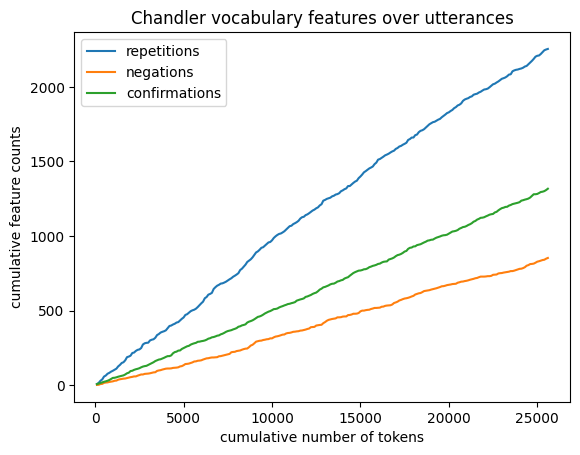

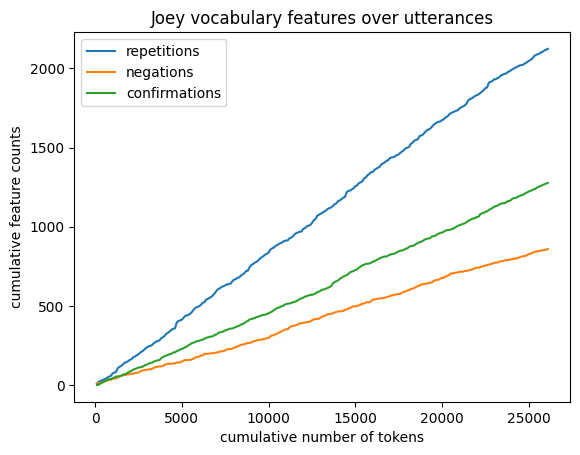

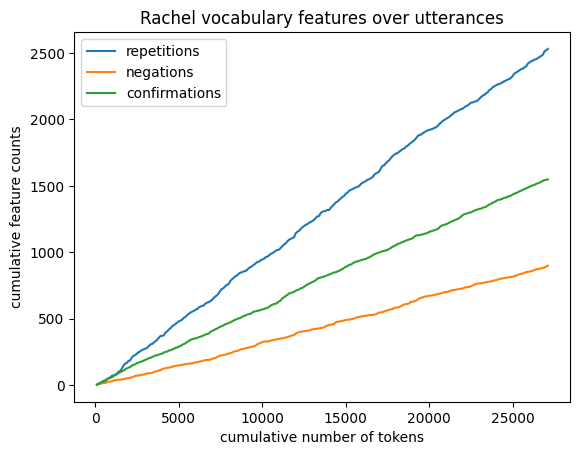

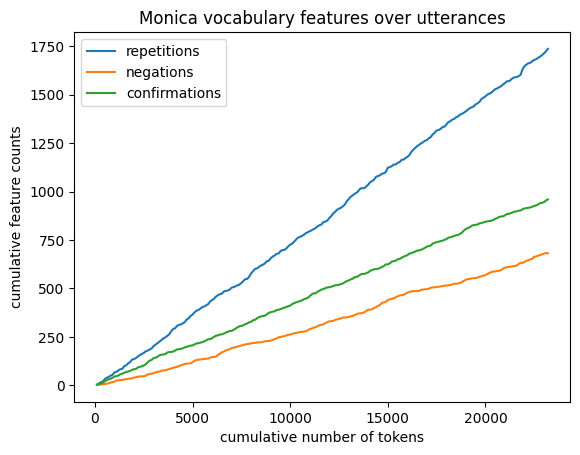

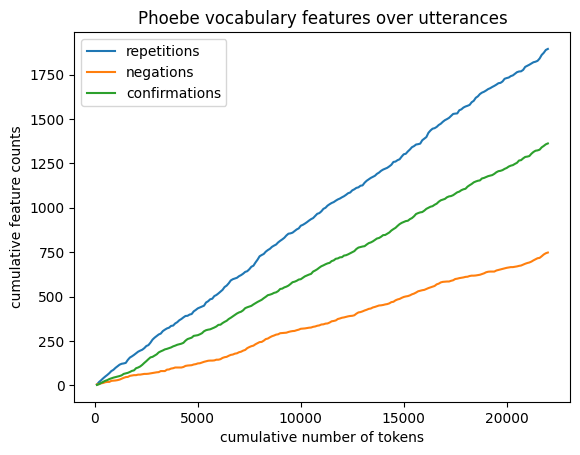

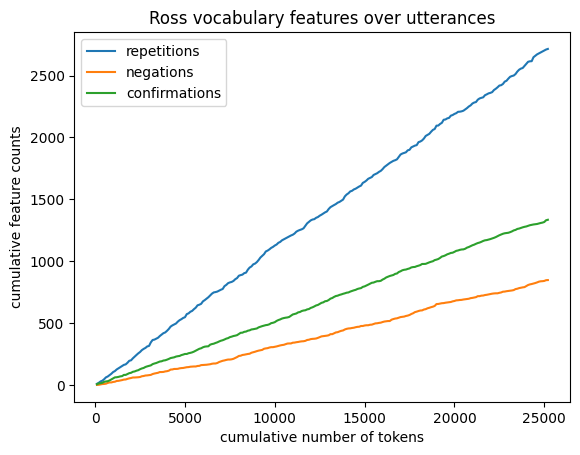

In [52]:
# Plotting vocabulary features over utterances for each speaker
import matplotlib.pyplot as plt

for speaker_name in distinct_speakers1:
    xs   = utterance_features[speaker_name]['token_count_arr']
    reps = utterance_features[speaker_name]['repitition_count_arr']
    negs = utterance_features[speaker_name]['negation_count_arr']
    conf = utterance_features[speaker_name]['confirmation_count_arr']
    plt.plot(xs, reps, label='repetitions')
    plt.plot(xs, negs, label='negations')
    plt.plot(xs, conf, label='confirmations')

    plt.xlabel('cumulative number of tokens')  
    plt.ylabel('cumulative feature counts')
    plt.title(speaker_name + ' vocabulary features over utterances')
    plt.legend()                            
    plt.show()                               

Calculate the overall personality for each speaker by 
averaging over all instances of the original dataset,
and comment on possible similarities and differences between speakers
and whether some attributes are more associated with some personality patterns.

In [53]:
import numpy as np
import ast
for speaker_name in distinct_speakers1:
    # read original file and find speaker 1 as cuurent speaker, get their personality columns and average at last
    # traverse df to find rows where speaker 1 is the current speaker
    speaker_df = df.loc[df['Speaker_1']==speaker_name]
    # get Personality   column, which is an array for big 5 traits [1,2,0.4,0.6,0.9]
    personality = speaker_df['Personality'].values
    personality_arrays = np.array(
        speaker_df['Personality'].apply(ast.literal_eval).tolist()
    )
    print(f"{speaker_name} personality traits: {personality[0]}")    
    avg = np.mean(personality_arrays, axis=0)
    print(f"{speaker_name} average personality traits: {avg}")

Chandler personality traits: [0.648, 0.375, 0.386, 0.58, 0.477]
Chandler average personality traits: [0.648 0.375 0.386 0.58  0.477]
Joey personality traits: [0.574, 0.614, 0.297, 0.545, 0.455]
Joey average personality traits: [0.574 0.614 0.297 0.545 0.455]
Rachel personality traits: [0.635, 0.354, 0.521, 0.552, 0.469]
Rachel average personality traits: [0.635 0.354 0.521 0.552 0.469]
Monica personality traits: [0.713, 0.457, 0.457, 0.66, 0.511]
Monica average personality traits: [0.713 0.457 0.457 0.66  0.511]
Phoebe personality traits: [0.6, 0.48, 0.31, 0.46, 0.56]
Phoebe average personality traits: [0.6  0.48 0.31 0.46 0.56]
Ross personality traits: [0.722, 0.489, 0.6, 0.533, 0.356]
Ross average personality traits: [0.722 0.489 0.6   0.533 0.356]


### 2
We want to evaluate the extent to which a speaker changes topic during conversation

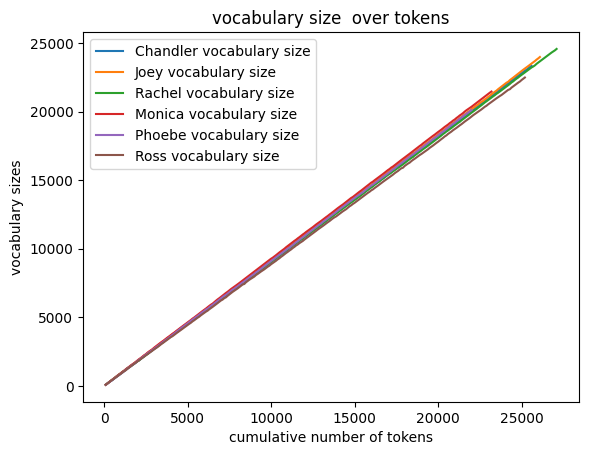

In [54]:
# plots the evolution of the vocabulary size with respect to the number of tokens employed 
   
import matplotlib.pyplot as plt

for speaker_name in distinct_speakers1:
    xs   = utterance_features[speaker_name]['token_count_arr']
    vocs = utterance_features[speaker_name]['vocab_count_arr']
    plt.plot(xs, vocs, label= speaker_name + ' vocabulary size')
plt.xlabel('cumulative number of tokens')  
plt.ylabel('vocabulary sizes')
plt.title('vocabulary size  over tokens')
plt.legend()                            
plt.show() 




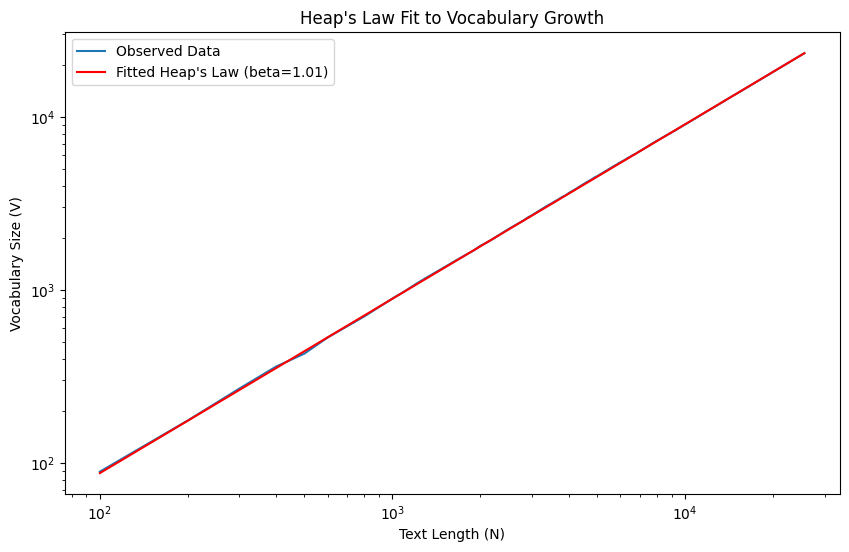

In [55]:

# Use log-log to fit heaps' law - chandler only
def heaps_law(N, K, beta):
    return K * N**beta
from scipy.optimize import curve_fit
popt, pcov = curve_fit(heaps_law, utterance_features['Chandler']['token_count_arr'], utterance_features['Chandler']['vocab_count_arr'], p0=[100, 0.5], maxfev=5000)
K_est, beta_est = popt
# Plot results
plt.figure(figsize=(10, 6))
plt.loglog(utterance_features['Chandler']['token_count_arr'], utterance_features['Chandler']['vocab_count_arr'], label='Observed Data')
plt.loglog(utterance_features['Chandler']['token_count_arr'], heaps_law(utterance_features['Chandler']['token_count_arr'], K_est, beta_est), linestyle='-', color='red', label=f'Fitted Heap\'s Law (beta={beta_est:.2f})')
plt.xlabel('Text Length (N)')
plt.ylabel('Vocabulary Size (V)')
plt.title('Heap\'s Law Fit to Vocabulary Growth')
plt.legend()
plt.show()

determine the topic number use  (need reference paper)
- Use coherence score
- Use perlexity score

In [56]:
# remove stop words (contribute noting to topic modeling)
# lemmatization
#  try different topic numbers and evaluate coherence and perlexity scores
# choose the topic number that give high coherence and low perlexity

In [102]:

# Read each main character's utterances from CSV files
import pandas as pd
df_Chandler = pd.read_csv('Chandler_utterances.csv')
df_Monica = pd.read_csv('Monica_utterances.csv')
df_Ross = pd.read_csv('Ross_utterances.csv')
df_Rachel = pd.read_csv('Rachel_utterances.csv')
df_Joey = pd.read_csv('Joey_utterances.csv')
df_Phoebe = pd.read_csv('Phoebe_utterances.csv')

# remove stop words and lemmatization and spoken words(spoken words are not useful for topic modeling, but useful for sentiment analysis)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words('english'))
spoken_words = {
    'uh','um','oh','ah','ooh','eh','huh','wow','hey','hi','hello','bye','ok','okay',
    'yeah','yep','yup','yes','yah','nah','no','nope','right','exactly','absolutely',
    'like','well','so','then','just','really','actually','basically','literally',
    'kinda','sorta','gonna','gotta','wanna',"y'know","i mean","you know",
    'fine','great','cool','sure','alright','whatever','whatever','hmm',
    'man','dude','guys','folks'
}
tokenizer = RegexpTokenizer(r"[A-Za-z']+")
lemmatizer = WordNetLemmatizer()
def preprocess_texts(df):
    utterances = df['utterance'].str.lower().tolist()
    processed_texts = []
    for sentence in utterances:
        tokens = tokenizer.tokenize(sentence)
        filtered_tokens = [lemmatizer.lemmatize(t) for t in tokens
                   if t not in stop_words and t.lower() not in spoken_words]
        processed_texts.append(filtered_tokens)
    return processed_texts
text_chandler = preprocess_texts(df_Chandler)
text_monica   = preprocess_texts(df_Monica)
text_ross     = preprocess_texts(df_Ross)
text_rachel   = preprocess_texts(df_Rachel)
text_joey     = preprocess_texts(df_Joey)
text_phoebe   = preprocess_texts(df_Phoebe)

print(text_chandler)
print(len(text_chandler))
        
        

[['also', 'point', 'person', 'company', 'transition', 'kl', 'gr', 'system'], [], ['duty'], ['see'], ['good', 'know'], ['beg'], ['mon'], ['ever'], ['way'], ['coffee', 'hang'], ['get', 'beer'], ['betcha'], ['good', 'job', 'joe', 'done', 'top', 'notch'], ['ho', 'ho'], ['whole', 'thing', 'go'], ['love', 'specific', 'specific', 'best', 'part'], ['enough', 'honey'], [], ['hold', 'moment', 'another', 'call', 'love'], ['back'], ["'bout", 'tomorrow', 'afternoon', 'know', 'central', 'perk', 'village', 'say', 'five', 'ish'], ['phone', 'finally', 'paid'], ['hoping', 'bob', 'show', 'seek', 'comfort', 'open', 'arm', 'wry', 'stranger', 'next', 'table'], [], ['toilet'], ['sound', 'hernia', 'go', 'doctor'], ['want', 'hint'], ['pocket', 'pheebs'], ['thanks'], ['ridiculous', 'name'], ['ticket', 'please', 'courtside', 'baby'], ['seriously', 'want'], [], [], ['dana', 'keystone', 'college'], ['god', "victoria's", 'secret', 'model', 'something', 'something', 'goodacre'], ['jill', 'jill', 'goodacre', 'god', '

In [103]:
from gensim import corpora, models

def train_model_with_different_topic_numbers(speaker_name, texts, k_range):
    dictionary = corpora.Dictionary(texts)
    corpus     = [dictionary.doc2bow(t) for t in texts]

    split = int(0.8 * len(corpus))
    train_corpus, test_corpus = corpus[:split], corpus[split:]
    train_texts,  test_texts  = texts[:split],  texts[split:]
    c_scores, p_scores = [], []
    for k in k_range:
        lda = models.LdaModel(train_corpus, id2word=dictionary, num_topics=k,
                    passes=10, random_state=42)
        cm = models.CoherenceModel(model=lda, corpus=train_corpus, texts=train_texts,
                            coherence='c_v')
        c_scores.append((k, cm.get_coherence()))
        p_scores.append((k, lda.log_perplexity(test_corpus)))
    return c_scores, p_scores
   
        
       

In [104]:
k_range = range(1, 12)
user_scores = {}
for speaker_name in distinct_speakers1:
    user_scores[speaker_name] = train_model_with_different_topic_numbers(
        speaker_name,
        globals()[f'text_{speaker_name.lower()}'],
        k_range
    )



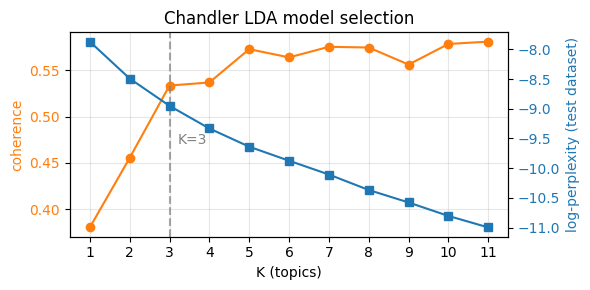

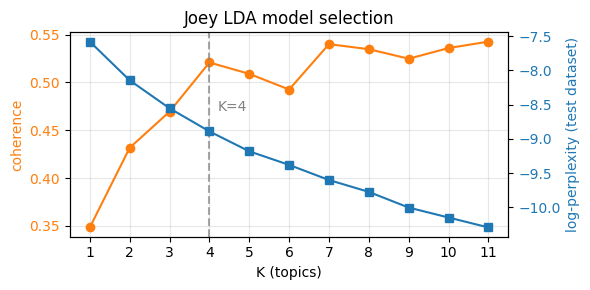

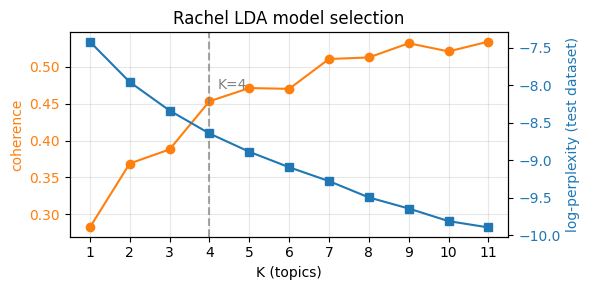

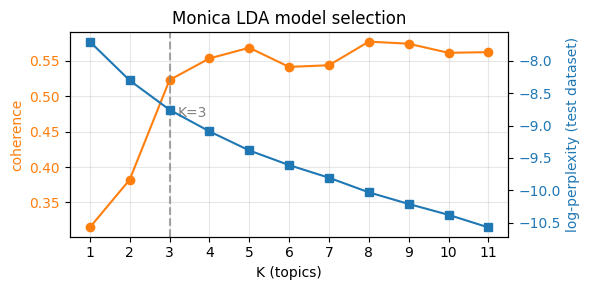

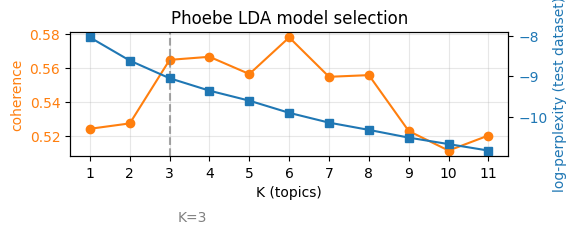

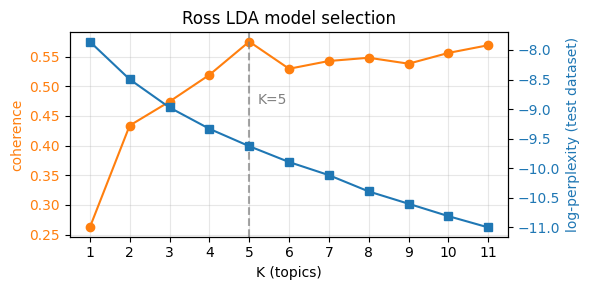

In [105]:
import matplotlib.pyplot as plt
import numpy as np

def norm(x, high_good=True):
    return (x - x.min()) / (x.ptp()) if high_good else (x.max() - x) / x.ptp()

best_ks = {}

for speaker_name in distinct_speakers1:
    c_scores, p_scores = user_scores[speaker_name]
    K, coh, perp = map(np.array, zip(*[(k, c, p) for (k, c), (_, p) in zip(c_scores, p_scores)]))
    # search reference for this line (how to find best k, why normalize)
    best_k = int(K[(norm(coh) - norm(perp, high_good=False)).argmax()])
    best_ks[speaker_name] = best_k

    topic_number, coherence_score = zip(*c_scores)
    topic_number_2, perplexity_score = zip(*p_scores)

    fig, ax1 = plt.subplots(figsize=(6,3))

    # --- coherence axis (left) ---
    ax1.set_xticks(topic_number)
    ax1.plot(topic_number, coherence_score, 'o-', color='tab:orange', label='coherence')
    ax1.set_ylabel('coherence', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_xlabel('K (topics)')
    ax1.grid(alpha=.3)

    # --- perplexity axis (right) ---
    ax2 = ax1.twinx()
    ax2.plot(topic_number_2, perplexity_score, 's-', color='tab:blue', label='log-perplexity')
    ax2.set_ylabel('log-perplexity (test dataset)', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # --- annotate best K ---
    ax1.axvline(best_k, color='grey', ls='--', alpha=.7)
    ax1.text(best_k+.2, 0.47, f'K={best_k}', color='grey')

    plt.title(f'{speaker_name} LDA model selection')
    plt.tight_layout()
    plt.show()

In [106]:
# List of topics for each character with the best K

print(best_ks)
best_topics = {}
for speaker_name in distinct_speakers1:
    best_k = best_ks[speaker_name]
    best_topics[speaker_name] = [f"Topic {i}" for i in range(best_k)]

{'Chandler': 3, 'Joey': 4, 'Rachel': 4, 'Monica': 3, 'Phoebe': 3, 'Ross': 5}


In [98]:
# train final LDA models with the best K for each character
final_lda_models = {}
for speaker_name in distinct_speakers1:
    best_k = best_ks[speaker_name]
    texts = globals()[f'text_{speaker_name.lower()}']
    dictionary = corpora.Dictionary(texts)
    corpus     = [dictionary.doc2bow(t) for t in texts]
    final_lda_models[speaker_name] = models.LdaModel(corpus, id2word=dictionary, num_topics=best_k,
                    passes=10, random_state=42)

In [101]:
# print topic list for each character
for speaker_name in distinct_speakers1:
    lda = final_lda_models[speaker_name]
    print(f'\n{speaker_name}  (K={lda.num_topics})')
    rows = []
    for t_id in range(lda.num_topics):
        top10 = [f'{w} ({p:.3f})' for w, p in lda.show_topic(t_id, topn=10)]
        rows.append([f'Topic {t_id+1}'] + top10)
    print(tabulate(rows, headers=['Topic'] + [f'Word {i+1}' for i in range(10)]))


Chandler  (K=4)
Topic    Word 1         Word 2         Word 3         Word 4        Word 5        Word 6          Word 7         Word 8        Word 9          Word 10
-------  -------------  -------------  -------------  ------------  ------------  --------------  -------------  ------------  --------------  --------------
Topic 1  think (0.035)  know (0.035)   well (0.030)   go (0.024)    one (0.016)   okay (0.016)    oh (0.015)     got (0.014)   going (0.014)   that's (0.013)
Topic 2  oh (0.039)     look (0.028)   gonna (0.025)  get (0.022)   say (0.020)   really (0.018)  great (0.017)  make (0.013)  god (0.012)     y'know (0.011)
Topic 3  yeah (0.061)   right (0.035)  yes (0.031)    oh (0.022)    like (0.021)  uh (0.021)      mean (0.014)   know (0.011)  please (0.009)  rachel (0.009)
Topic 4  okay (0.047)   hey (0.038)    well (0.037)   like (0.024)  oh (0.018)    want (0.016)    come (0.015)   joey (0.013)  get (0.011)     ah (0.011)

Joey  (K=1)
Topic    Word 1        Word 2    

### 3.
We want to test whether some emotion patterns are occurring with some particular personality trait